### **IiA 20139, ENERGY AND POWER QUALITY CALCULATIONS**
Version 2 with flat-top window

# Python list

First, read in data in one go, from a text file of sample data:

In [777]:
TESTDATA = 'data_sample_10_seconds.out'

In [778]:
with open(TESTDATA) as f:
    sampledata = f.read()
print(sampledata[0:300])

      0.0000    342.398    0.16775     57.437    0.0001144
      0.1280    342.887    0.22326     76.553    0.0000877
      0.2560    343.229    0.25986     89.192    0.0000771
      0.3840    343.571    0.27938     95.987    0.0000746
      0.5120    343.816    0.27938     96.055    0.0000485
     


# Numpy

We use numpy to get the benefit of much faster compiled calculations on numeric arrays. Functions available can be found here [numpy](https://numpy.org/doc/stable/reference/routines.math.html). We get the data loaded directly into a numpy array as follows:

In [779]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [780]:
alldata = np.loadtxt(sampledata.split('\n'), encoding='utf-8')
print(alldata[0:5])


[[0.00000e+00 3.42398e+02 1.67750e-01 5.74370e+01 1.14400e-04]
 [1.28000e-01 3.42887e+02 2.23260e-01 7.65530e+01 8.77000e-05]
 [2.56000e-01 3.43229e+02 2.59860e-01 8.91920e+01 7.71000e-05]
 [3.84000e-01 3.43571e+02 2.79380e-01 9.59870e+01 7.46000e-05]
 [5.12000e-01 3.43816e+02 2.79380e-01 9.60550e+01 4.85000e-05]]


We use the last 15625 samples, representing 2 seconds of data.

In [781]:
n_samples = 15625
somedata = alldata[-n_samples:,:]
print(somedata[0:3,:])

[[ 8.000128e+03 -5.628400e+01 -4.026000e-02  2.266000e+00  1.164000e-04]
 [ 8.000256e+03 -6.973100e+01 -4.148000e-02  2.892000e+00  1.177000e-04]
 [ 8.000384e+03 -8.327700e+01 -4.087000e-02  3.404000e+00  9.710000e-05]]


Numpy supports proper multidimensional arrays. To access individual elements, we can do this:

In [782]:
print(somedata[1,2])

-0.04148


# Label data columns

In [783]:
timestamps = somedata[:,0]
voltages = somedata[:,1]
currents = somedata[:,2]
powers = somedata[:,3]
leakage_currents = somedata[:,4]

# Time domain plot

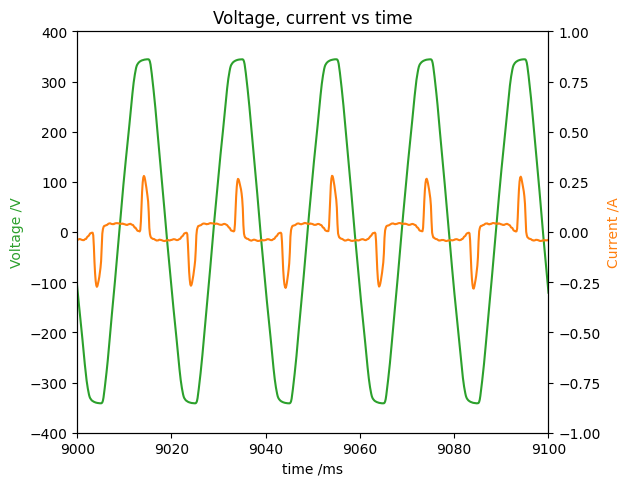

In [784]:
x = timestamps
y1 = voltages
y2 = currents
fig, ax1 = plt.subplots()
# first plot
ax1.set_xlabel('time /ms')
ax1.set_xlim([9000,9100])
ax1.set_ylabel('Voltage /V', color='tab:green')
ax1.set_ylim([-400,400])
ax1.plot(x,y1, color='tab:green')
# second plot
ax2 = ax1.twinx()
ax2.set_ylabel('Current /A', color='tab:orange')
ax2.set_ylim([-1,1])
ax2.plot(x,y2, color='tab:orange')
fig.tight_layout()
plt.title('Voltage, current vs time')
plt.show()


# Calculations, time domain
Now that we have the data in a fast array, let's do some electrical calculations. Start with finding the mean value for all four channels:

## Mean

In [785]:
means = [ np.mean(voltages), np.mean(currents), np.mean(powers), np.mean(leakage_currents) ]
print('Mean: ', means)


Mean:  [1.528321663999999, 0.00017017536000000054, 14.309145216000001, 4.8014592e-06]


## Max/min

In [786]:
maxes = [ np.max(voltages), np.max(currents), np.max(powers), np.max(leakage_currents) ]
mins =  [ np.min(voltages), np.min(currents), np.min(powers), np.min(leakage_currents) ]
max_abs = [ np.max(np.abs(voltages)), np.max(np.abs(currents)), np.max(np.abs(powers)), np.max(np.abs(leakage_currents)) ]
print('Maxima: ', maxes)
print('Minima: ', mins)
print('Max abs:', max_abs)


Maxima:  [344.647, 0.62281, 238.721, 0.0002324]
Minima:  [-341.469, -0.70577, -10.195, -0.000217]
Max abs: [344.647, 0.70577, 238.721, 0.0002324]


## RMS

In [787]:
rmses = [ math.sqrt(np.mean(np.square(voltages))), math.sqrt(np.mean(np.square(currents))), math.sqrt(np.mean(np.square(powers))), math.sqrt(np.mean(np.square(leakage_currents))) ]
print('RMS values:', rmses)

RMS values: [251.639605358279, 0.10843917419155866, 35.9019096743825, 9.15611890040753e-05]


## Crest factors.
The zip function combines two lists into one list of two-tuples. This allows us to iterate over two sets of data (peak and average) simultaneously:

In [788]:
# Calculate crest factor for voltage, current and leakage current
# NB Crest factor is not defined for power quantities.
crests = [ max/rms for max, rms in zip(max_abs, rmses) ]
print('Crest factors: ', crests[0], crests[1], crests[3])

Crest factors:  1.3696055496085326 6.508441301417989 2.538193338551513


## Frequency

In [789]:
# Find all rising slope zero crossings of voltage (column 0 is time and column 1 is voltage)
ts = [ timestamps[i] for i in np.arange(0, n_samples-1) if voltages[i] < 0.0 and voltages[i+1] >= 0.0 ]
# Count the number of them
n = len(ts)
print(n)
# Find the timestamp of first and last zero crossing
print(ts[0], ts[-1])
# Divide the time taken by the number of zero crossings, to figure out the average period
period = (ts[-1] - ts[0])/1000.0/n
# Reciprocate the period to find the frequency.
frequency = 1.0/period
print(f'Period:    {period :10.5f} s')
print(f'Frequency: {frequency :10.2f} Hz')

100
8009.472 9988.096
Period:       0.01979 s
Frequency:      50.54 Hz


## Power, VA

In [790]:
power = means[2]
va = rmses[0] * rmses[1]
print(f'Power: {power :10.3f}')
print(f'VA:    {va: 10.3f}')

Power:     14.309
VA:        27.288


## Power factor

In [791]:
pf = power/va
print(f'pf: {pf :10.3f}')

pf:      0.524


## All together

In [792]:
# dictionary of results
results = {}
results['rms_voltage'] = rmses[0]
results['rms_current'] = rmses[1]
results['rms_leakage_current'] = rmses[3]
results['peak_voltage'] = max_abs[0]
results['peak_current'] = max_abs[1]
results['peak_power'] = max_abs[2]
results['peak_leakage_current'] = max_abs[3]
results['mean_power'] = means[2]
results['mean_apparent_power'] = va
results['power_factor'] = pf
results['period'] = period
results['frequency'] = frequency
results['power'] = power
results['crest_factor_voltage'] = crests[0]
results['crest_factor_current'] = crests[1]
results['crest_factor_leakage_current'] = crests[3]

for k in results:
    print(f'{k :30}: {results[k] :10.5f}')


rms_voltage                   :  251.63961
rms_current                   :    0.10844
rms_leakage_current           :    0.00009
peak_voltage                  :  344.64700
peak_current                  :    0.70577
peak_power                    :  238.72100
peak_leakage_current          :    0.00023
mean_power                    :   14.30915
mean_apparent_power           :   27.28759
power_factor                  :    0.52438
period                        :    0.01979
frequency                     :   50.54017
power                         :   14.30915
crest_factor_voltage          :    1.36961
crest_factor_current          :    6.50844
crest_factor_leakage_current  :    2.53819


# Calculations, frequency domain

The distance between frequency bins is equal to the sample rate divided by the number of samples. Therefore with a sample rate of 7812.5 Sa/s, and 7812 samples, the width of frequency bins is 1.000064 Hz.

A window function is applied to prevent discontinuity in the time domain at the beginning and end of the sample range from causing spectral leakage (error in the fft result).


## Window function

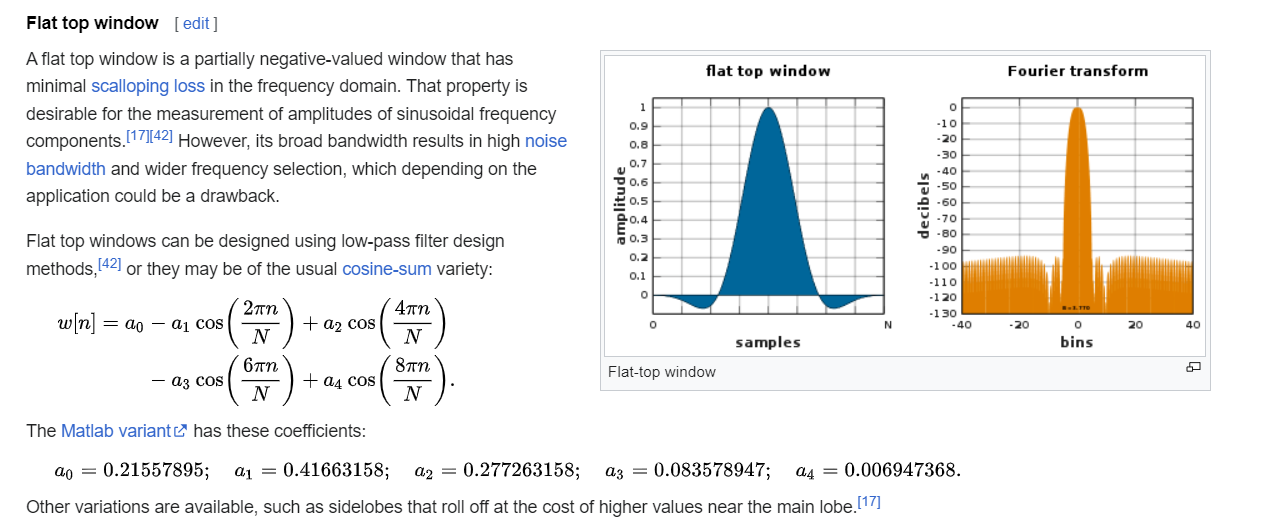

In [793]:
# Define a flat-top window function
# NB available in scipy, but this avoids importing another big library
# On test, flattop produces large error for DC component at 0.5Hz, so it
# is essential to filter only the 'desired' frequencies, ie integer multiples
# of the measured nominal frequency of the data. Other than that, it produces
# the best amplitude accuracy of all the window functions.
def create_flattop_window(N):
    a0 = 0.21557895
    a1 = 0.41663158
    a2 = 0.277263158
    a3 = 0.083578947
    a4 = 0.006947368
    flattop_window = [ a0 - a1*math.cos(2*math.pi*n/N)
                          + a2*math.cos(4*math.pi*n/N)
                          - a3*math.cos(6*math.pi*n/N)
                          + a4*math.cos(8*math.pi*n/N) for n in range(N) ]
    return flattop_window

# rectangular window is very simple and works provided the samples are
# exactly periodic in the sample set.
def create_rectangular_window(N):
    rectangular_window = [ 1.0 for n in range(N) ]
    return rectangular_window

# blackman window is available as a library function in Numpy. It's more
# forgiving than the others, at the expense of some accuracy in the result.
def create_blackman_window(N):
    blackman_window = np.blackman(N)
    return blackman_window



## Display window function

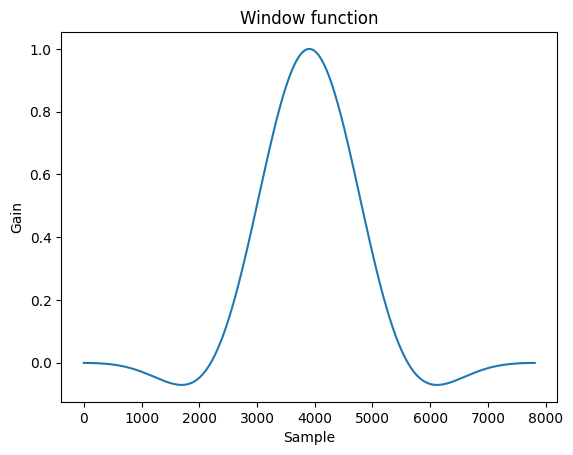

In [794]:
def draw_window(window):
    plt.plot(window)
    plt.title('Window function')
    plt.ylabel('Gain')
    plt.xlabel('Sample')
    plt.show()

sample_rate = 7812.5
n_samples = 7812    # reduce the number of samples used for the FFT
# NB the 'bin size' is sample_rate/n_samples, the number of bins
# is n_samples/2 + 1 (ie inclusive of the DC bin).

# select window function
#window = create_blackman_window(n_samples)
window = create_flattop_window(n_samples)
#window = create_rectangular_window(n_samples)

draw_window(window)

In [795]:
def fft(samples, window, sample_rate):
    N = len(samples)
    root2 = math.sqrt(2)
    window_average = np.mean(window)

    # apply window to samples
    fft_out = np.fft.rfft(np.multiply(samples, window), norm='forward')

    # extract a list of the frequencies of the fft bins
    bins = np.fft.rfftfreq(N, 1/sample_rate)
    # all the amplitude cooefficients need to be adjusted for the window
    # average amplitude and root2. The root2 term is actually a reduction of
    # 2/root2, the '2' required to account for the energy in the negative
    # frequency part of the fft, not included in the rfft, and the /root2 to
    # account for the fact that we want to display rms amplitudes, not peak
    # amplitudes
    mags = [ v * root2 / window_average for v in np.abs(fft_out) ]
    # however, the dc cooefficient does not need the 2/root2 term, so we
    # remove that here
    mags[0] = mags[0] / root2
    # we don't use the phase angles, but they are available
    phases = np.angle(fft_out)
    return(bins, mags)


def draw_fft(freqs, mags, title='Harmonics', y_label='Amplitude', color='tab:blue'):
    plt.plot(freqs, mags, color=color)
    plt.title(title)
    plt.xlabel('Frequency /Hz')
    plt.ylabel(y_label, color=color)
    plt.show()

def draw_fft_bar(freqs, mags, title='Harmonics', y_label='Amplitude', color='tab:blue'):
    plt.bar(freqs, mags, width=5, color=color)
    plt.title(title)
    plt.xlabel('Frequency /Hz')
    plt.ylabel(y_label, color=color)
    plt.show()


## Harmonic voltage magnitudes

In [796]:
bins, mags = fft(voltages[-n_samples:], window, sample_rate)
frequency_vs_voltage = [*zip(bins, mags)]

print(frequency_vs_voltage[1:20])

[(1.0000640040962623, 2.1969840149322946), (2.0001280081925246, 1.4627647394464602), (3.000192012288787, 0.44212656624933383), (4.000256016385049, 0.038981638916188), (5.000320020481311, 0.0022717652046586527), (6.000384024577574, 0.0033249569501132116), (7.000448028673836, 0.0032637515619160355), (8.000512032770098, 0.003354362663173696), (9.000576036866361, 0.002893815703157577), (10.000640040962622, 0.001805695617677727), (11.000704045058885, 0.0005487093625558021), (12.000768049155148, 0.0018725166411264933), (13.00083205325141, 0.0021970906178004042), (14.000896057347672, 0.002868982605102172), (15.000960061443934, 0.0026837866809155168), (16.001024065540197, 0.002365323888529787), (17.00108806963646, 0.004064680576753054), (18.001152073732722, 0.004353055753382098), (19.001216077828982, 0.004010256970647055)]


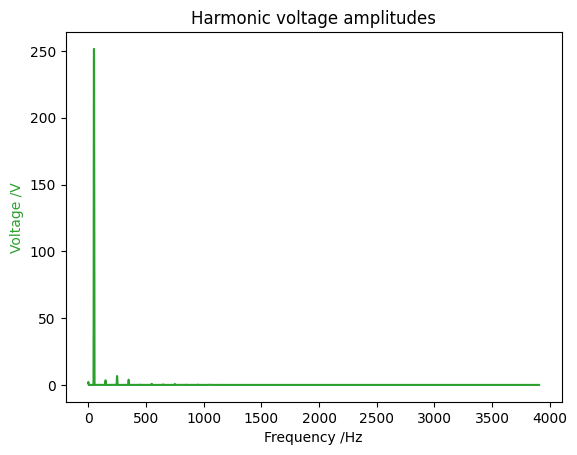

In [797]:
pd = dict(frequency_vs_voltage)
draw_fft(pd.keys(), pd.values(), 'Harmonic voltage amplitudes', 'Voltage /V', color='tab:green')

## Harmonic current magnitudes

Generate the FFT for the current data:

In [798]:
bins, mags = fft(currents[-n_samples:], window, sample_rate)
frequency_vs_current = [*zip(bins, mags)]

print(frequency_vs_current[1:20])

[(1.0000640040962623, 0.0012249362615327259), (2.0001280081925246, 0.0014841119683264344), (3.000192012288787, 0.0014065652428972085), (4.000256016385049, 0.0006740326101120193), (5.000320020481311, 0.00022186685966224596), (6.000384024577574, 0.0008708521060597584), (7.000448028673836, 0.0015139022750296162), (8.000512032770098, 0.0014630750604108704), (9.000576036866361, 0.0010577054689067849), (10.000640040962622, 0.00025733535303003796), (11.000704045058885, 0.0007292636815824061), (12.000768049155148, 0.0008385401588011139), (13.00083205325141, 0.0012605542626159254), (14.000896057347672, 0.0010070713517678182), (15.000960061443934, 0.0004842579629088931), (16.001024065540197, 0.0006607626206796111), (17.00108806963646, 0.0010969663943431506), (18.001152073732722, 0.0012382030003454515), (19.001216077828982, 0.0010814041929805233)]


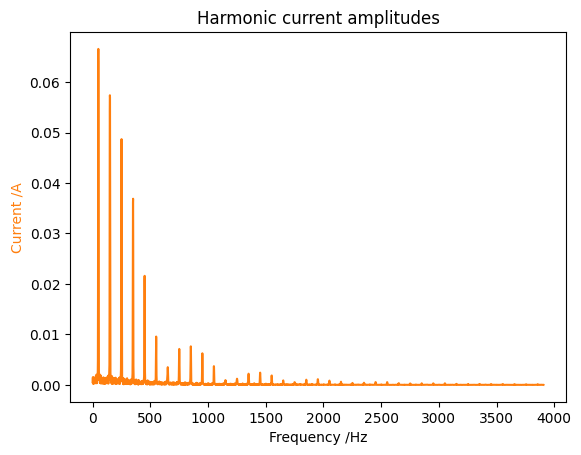

In [799]:
pd = dict(frequency_vs_current)
draw_fft(pd.keys(), pd.values(), 'Harmonic current amplitudes', 'Current /A', color='tab:orange')

## Correctness tests

Generate FFTs for some artificial test data. This helps to convince us that we have got the amplitude of the harmonic voltages right.

In [800]:
def generate_sine_points(frequency, amplitude, sample_rate, n_points):
    """Generate an array of time series points with sine function."""
    out = [ amplitude * math.sin(2*math.pi*frequency*i/sample_rate) for i in range(n_points) ]
    return out

def generate_composite_points(freq, coefficients):
    """Generate an array of time-domain points corresponding to given harmonic magnitude
    coefficients."""
    # initialise array of floating point samples
    composite_points = np.zeros(n_samples, dtype=np.float32)
    # add components
    root2 = math.sqrt(2)
    for (o,m) in coefficients:
        if o == 0:
            composite_points = composite_points + np.full(n_samples, m, dtype=np.float32)
        else:    
            f = o*freq
            vs = generate_sine_points(f, m*root2, sample_rate, n_samples)
            composite_points = composite_points + np.array(vs, dtype=np.float32)
    return composite_points

def simulated_test(freq, coefficients):
    """For given frequency and harmonic coefficients, calculate time series data, then
    calculate the fft."""
    composite_points = generate_composite_points(freq, coefficients)
    bins, mags = fft(composite_points, window, sample_rate)
    # Flat-top window is susceptible to error/overshoot near DC, although DC
    # coefficient itself is correct. So we set the nearby bins to zero.
    for i in [1,2,3,4]:
        mags[i] = 0.0
    return (bins, mags)
    
def filter_fft(freq, bins, mags):
    """Filter the fft coefficients to include only those that are multiples of the 
    fundamental signal frequency."""
    # We need to filter the fft for the correct harmonic frequencies.
    # Plan is to take the fundamental frequency, multiply by the harmonic order
    # and then round to nearest 1.0Hz.
    # Filtering is essential for flat top window, which has an error near DC, although
    # the DC coefficient itself is correct
    harmonic_frequencies = [ round(freq*h) for h in range(0, 51) ]
    filtered_fft = [ (f,m) for f,m in zip(bins, mags) if round(f) in harmonic_frequencies ]
    # convert back into two lists
    f_bins, f_mags = zip(*filtered_fft)
    return (f_bins, f_mags)
    

### Accuracy test
accuracy_test() generates all bins for a test signal with selected fundamental frequency and contrived harmonic magnitude coefficients.

In [801]:
freq = 50.1
coefficients = [(0,2), (1,3), (3,1), (5,2), (50,0.5)]
bins, mags = simulated_test(freq, coefficients)
f_bins, f_mags = filter_fft(freq, bins, mags)
print([*zip(f_bins, f_mags)])

[(0.0, 1.9999853235838714), (50.00320020481311, 3.0001882392986743), (100.00640040962622, 2.00515125971541e-05), (150.00960061443934, 1.000258082584024), (200.01280081925245, 2.1862619848872982e-05), (250.01600102406556, 1.9982249590137933), (301.01926523297493, 2.4828582824855733e-05), (351.02246543778807, 1.3397087731680951e-05), (401.02566564260115, 9.280879749206261e-06), (451.0288658474143, 7.163921989835656e-06), (501.0320660522274, 5.866817219159224e-06), (551.0352662570405, 4.9926217080367534e-06), (601.0384664618537, 4.362338304258961e-06), (651.0416666666667, 3.8905331958208635e-06), (701.0448668714798, 3.52110165825669e-06), (752.0481310803892, 3.194615390094113e-06), (802.0513312852023, 2.9463357394434347e-06), (852.0545314900155, 2.741776830295613e-06), (902.0577316948286, 2.564504541394344e-06), (952.0609318996417, 2.40667577315267e-06), (1002.0641321044548, 2.2708080955904177e-06), (1052.0673323092678, 2.1537289830072654e-06), (1102.070532514081, 2.050259427610099e-06), 

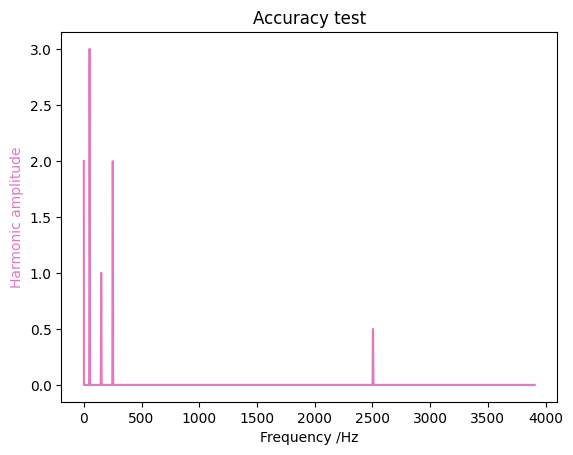

In [802]:
freqs, mags = accuracy_test_result
draw_fft(freqs, mags, 'Accuracy test', 'Harmonic amplitude', color='tab:pink')

### Sensitivity test
We try the calculation for a range of fundamental frequencies +/- 0.1Hz increments to verify that the correct result is computed even if the harmonic energy shifts to different FFT bins

In [803]:
coefficients = [(0,2), (1,3), (3,1), (5,2), (50,0.5)]
for freq in [49.5, 49.6, 49.7, 49.8, 49.9, 50.0, 50.1, 50.2, 50.3, 50.4, 50.5]:
    bins, mags = simulated_test(freq, coefficients)
    f_bins, f_mags = filter_fft(freq, bins, mags)
    print(f'Freq: {freq}')
    for f,v in zip(f_bins, f_mags):
        if v>0.1:
            print(f' h{round(f/freq):<2}:       bin {f:8.2f} Hz = {v:6.3f}')

Freq: 49.5
 h0 :       bin     0.00 Hz =  2.000
 h1 :       bin    50.00 Hz =  2.997
 h3 :       bin   148.01 Hz =  0.999
 h5 :       bin   248.02 Hz =  1.997
 h50:       bin  2475.16 Hz =  0.500
Freq: 49.6
 h0 :       bin     0.00 Hz =  2.000
 h1 :       bin    50.00 Hz =  3.000
 h3 :       bin   149.01 Hz =  1.000
 h5 :       bin   248.02 Hz =  2.000
 h50:       bin  2480.16 Hz =  0.500
Freq: 49.7
 h0 :       bin     0.00 Hz =  2.000
 h1 :       bin    50.00 Hz =  3.001
 h3 :       bin   149.01 Hz =  1.000
 h5 :       bin   248.02 Hz =  1.998
 h50:       bin  2485.16 Hz =  0.500
Freq: 49.8
 h0 :       bin     0.00 Hz =  2.000
 h1 :       bin    50.00 Hz =  3.001
 h3 :       bin   149.01 Hz =  1.000
 h5 :       bin   249.02 Hz =  2.000
 h50:       bin  2490.16 Hz =  0.500
Freq: 49.9
 h0 :       bin     0.00 Hz =  2.000
 h1 :       bin    50.00 Hz =  3.000
 h3 :       bin   150.01 Hz =  1.000
 h5 :       bin   250.02 Hz =  1.997
 h50:       bin  2495.16 Hz =  0.500
Freq: 50.0
 h0 :    